<a href="https://colab.research.google.com/github/stvngo/Algoverse-AI-Model-Probing/blob/main/Linear_Probing_Qwen_3_0_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

When a model makes a correct prediction on a task it has been trained on, Probing classifeier can be used to identify if the model actually contains the relevant informatioin or knowledge required to make that prediction, or it is just making a lucky guess
- can be used to identify crucial insights for developing better models over time


### How it works

A nn takes it's input as a series of vectors, or representations, and transform them through a series of layers to produce an output
- develop representations that useful so that the final few layers of the network can be a good prediction

### Probes
- a features or representations from the model are easily seperable by a simple classifier ==> a probe
The only way the probe can perform well on this task is if the representation it is given are already good enough to make the prediction



## Using Qwen 3 0.6B to extract residual steam activations


In [1]:
# Install and load the model
!pip install transformers accelerate



In [2]:
# download the file using wget
!wget https://huggingface.co/datasets/codelion/Qwen3-0.6B-pts/raw/main/pivotal_tokens.jsonl -O pivotal_tokens.jsonl


--2025-07-26 21:30:16--  https://huggingface.co/datasets/codelion/Qwen3-0.6B-pts/raw/main/pivotal_tokens.jsonl
Resolving huggingface.co (huggingface.co)... 13.35.202.34, 13.35.202.121, 13.35.202.97, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1466895 (1.4M) [text/plain]
Saving to: ‘pivotal_tokens.jsonl’

pivotal_tokens.json 100%[===================>]   1.40M  3.23MB/s    in 0.4s    

2025-07-26 21:30:17 (3.23 MB/s) - ‘pivotal_tokens.jsonl’ saved [1466895/1466895]



In [3]:
# loading the transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import random
from tqdm import tqdm
import numpy as np
import json
import os

# Debug: Check if file exists
file_path = "pivotal_tokens.jsonl"
print(f"Checking file: {file_path}")
print(f"File exists: {os.path.exists(file_path)}")

if os.path.exists(file_path):
    print(f"File size: {os.path.getsize(file_path)} bytes")

    # Check first few lines of the file
    print("\nFirst 3 lines of the file:")
    with open(file_path, "r") as f:
        for i, line in enumerate(f):
            if i < 3:
                print(f"Line {i+1}: {line[:100]}...")  # Show first 100 chars
            else:
                break
else:
    print("ERROR: File does not exist!")
    print("Current working directory:", os.getcwd())
    print("Files in current directory:", os.listdir("."))

# Load dataset with debugging
print("\nAttempting to load data...")
pts_data = []

try:
    with open("pivotal_tokens.jsonl", "r") as f:
        line_count = 0
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                print(f"Skipping empty line {line_num}")
                continue

            try:
                data = json.loads(line)
                pts_data.append(data)
                line_count += 1

                # Show first entry structure
                if line_count == 1:
                    print(f"First entry keys: {list(data.keys())}")
                    print(f"First entry: {data}")

            except json.JSONDecodeError as e:
                print(f"JSON decode error on line {line_num}: {e}")
                print(f"Problematic line: {line[:200]}...")
                continue

    print(f"\nSuccessfully loaded {len(pts_data)} entries")

    if len(pts_data) > 0:
        # Check data structure
        first_entry = pts_data[0]
        print(f"First entry type: {type(first_entry)}")

        # Check for required keys
        required_keys = ["response", "pivotal_tokens"]
        for key in required_keys:
            if key in first_entry:
                print(f"✓ Has '{key}' key")
                if key == "response":
                    print(f"  Response length: {len(first_entry[key])}")
                    print(f"  Response preview: {first_entry[key][:100]}...")
                elif key == "pivotal_tokens":
                    print(f"  Pivotal tokens: {first_entry[key]}")
            else:
                print(f"✗ Missing '{key}' key")

        print(f"All keys in first entry: {list(first_entry.keys())}")
    else:
        print("No data loaded!")

except FileNotFoundError:
    print("ERROR: File 'pivotal_tokens.jsonl' not found!")
except Exception as e:
    print(f"ERROR loading data: {e}")
    import traceback
    traceback.print_exc()

print(f"\nFinal pts_data length: {len(pts_data)}")

# Only continue with model loading if we have data
if len(pts_data) > 0:
    print("Data loaded successfully, proceeding with model loading...")

    # Set seed
    torch.manual_seed(42)
    random.seed(42)

    # Load Qwen 0.6B
    print("Loading model...")
    model_name = "Qwen/Qwen3-0.6B"
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True)
    model.eval()
    print("Model loaded successfully!")

    # Example query
    query = "What is the capital of France?"
    inputs = tokenizer(query, return_tensors="pt").to("cuda")

    #Generation
    output_ids = model.generate(
        inputs["input_ids"],
        do_sample=True,
        temperature=0.6,
        top_p=1.0,
        top_k=50,
        max_new_tokens=100,
    )

    # We'll extract hidden states from layer 16
    LAYER_TO_HOOK = 15

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print("Generated text:", output_text)

    # Run the model to get the hidden states or logits
    with torch.no_grad():
        outputs = model(**inputs)

else:
    print("Cannot proceed without data. Please check the file and try again.")

Checking file: pivotal_tokens.jsonl
File exists: True
File size: 1466895 bytes

First 3 lines of the file:
Line 1: {"model_id": "Qwen/Qwen3-0.6B", "query": "A tomato plant has 100 tomatoes. Jane picks 1/4 of that nu...
Line 2: {"model_id": "Qwen/Qwen3-0.6B", "query": "A tomato plant has 100 tomatoes. Jane picks 1/4 of that nu...
Line 3: {"model_id": "Qwen/Qwen3-0.6B", "query": "A tomato plant has 100 tomatoes. Jane picks 1/4 of that nu...

Attempting to load data...
First entry keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
First entry: {'model_id': 'Qwen/Qwen3-0.6B', 'query': "A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week, she goes back and picks 20 more tomatoes, and the following week picks twice that number. What's the total number of fruits remaining on the tomato plant?", 'pivot_co

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Model loaded successfully!
Generated text: What is the capital of France? The correct answer is Paris. What is the capital of China? The correct answer is Beijing. What is the capital of Japan? The correct answer is Tokyo. What is the capital of India? The correct answer is New Delhi. What is the capital of Brazil? The correct answer is Rio de Janeiro. What is the capital of Argentina? The correct answer is Buenos Aires. What is the capital of Nigeria? The correct answer is Abuja. What is the capital of Mexico? The correct answer is


In [4]:
print(model)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

## PTSProbeDataset
1. Loads PTS samples(```text```, ```pivotal_tokens```)
2. Tokenizes using Qwen tokenizer
3. Captures residual activations at a chosen layer
4. Aligns pivotal tokens to labels
5. Returns(activation, is_pivotal_label) pairs

In [5]:
class PTSProbeDataset(Dataset):
    def __init__(self, samples, tokenizer, model, layer_index=15):
        self.samples = samples
        self.tokenizer = tokenizer
        self.model = model
        self.layer_index = layer_index
        self.residuals = []
        self.labels = []

        # Debug: Check initial data
        print(f"Initializing dataset with {len(samples)} samples")
        if len(samples) > 0:
            print(f"First sample keys: {list(samples[0].keys())}")
            print(f"Sample has 'pivot_context': {'pivot_context' in samples[0]}")
            print(f"Sample has 'pivot_token': {'pivot_token' in samples[0]}")

        self._prepare_data()

    def _get_activations_for_sample(self, encoded_input):
        # Method 1: Using hooks (fixed version)
        try:
            activations = {}

            def hook_fn(module, input, output):
                # Handle case where output might be a tuple (hidden_states, attention_weights, etc.)
                if isinstance(output, tuple):
                    # For most transformer layers, hidden states are the first element
                    activations["residual"] = output[0].detach()
                else:
                    activations["residual"] = output.detach()

            handle = self.model.model.layers[self.layer_index].register_forward_hook(hook_fn)

            with torch.no_grad():
                self.model(**encoded_input)

            handle.remove()

            return activations["residual"]

        except Exception as e:
            # Method 2: Fallback - use model's output_hidden_states
            print(f"Hook method failed ({e}), trying output_hidden_states...")
            with torch.no_grad():
                outputs = self.model(**encoded_input, output_hidden_states=True)
                # hidden_states is a tuple of (embedding_layer, layer_0, layer_1, ..., layer_n)
                # So layer_index corresponds to outputs.hidden_states[layer_index + 1]
                return outputs.hidden_states[self.layer_index + 1].detach()

    def _prepare_data(self):
        skipped_empty_resid = 0
        skipped_empty_labels = 0
        skipped_misalignment = 0
        skipped_no_context = 0
        skipped_no_pivot = 0
        successful_samples = 0

        for i, example in enumerate(tqdm(self.samples)):
            # Check for PTS format keys
            if "pivot_context" not in example:
                print(f"Sample {i}: Missing 'pivot_context' key")
                skipped_no_context += 1
                continue

            if "pivot_token" not in example:
                print(f"Sample {i}: Missing 'pivot_token' key")
                skipped_no_pivot += 1
                continue

            # Use PTS format fields
            text = example["pivot_context"]
            pivot_token = example["pivot_token"].strip()

            # Debug: Check text and pivot token
            if not text or not text.strip():
                print(f"Sample {i}: Empty pivot_context")
                skipped_no_context += 1
                continue

            # Enhanced pivot token validation
            if not pivot_token or len(pivot_token) <= 1:  # Skip single characters and spaces
                if i < 10:  # Only print for first 10 samples to avoid spam
                    print(f"Sample {i}: Pivot token too short or empty: '{pivot_token}'")
                skipped_no_pivot += 1
                continue

            if i < 3:  # Debug first few samples
                print(f"Sample {i}: Processing text of length {len(text)}")
                print(f"  Pivot token: '{pivot_token}'")
                print(f"  Text preview: {text[:100]}...")

            try:
                encoded = self.tokenizer(
                    text, return_offsets_mapping=True, return_tensors="pt", truncation=True
                )
                offsets = encoded["offset_mapping"][0].tolist()

                # Debug: Check tokenization
                if i < 3:
                    print(f"Sample {i}: Tokenized to {len(offsets)} tokens")

                # Move to device (check what device model is on)
                device = next(self.model.parameters()).device
                encoded = {k: v.to(device) for k, v in encoded.items() if k != "offset_mapping"}

                resid = self._get_activations_for_sample(encoded).squeeze(0)

                # Debug: Check activations
                if i < 3:
                    print(f"Sample {i}: Got residuals shape {resid.shape}")

                # Create binary labels: 1 if token contains the pivot token, 0 otherwise
                token_labels = []
                pivot_token_lower = pivot_token.lower()

                for j, (start, end) in enumerate(offsets):
                    if start == 0 and end == 0:  # Special tokens
                        token_labels.append(0)
                    else:
                        token_text = text[start:end].lower()
                        # Check if this token matches or contains the pivot token
                        is_pivotal = int(pivot_token_lower in token_text or token_text in pivot_token_lower)
                        token_labels.append(is_pivotal)

                        # Debug: Print token matches for first few samples
                        if i < 3 and is_pivotal:
                            print(f"  Found pivot match - Token {j}: '{token_text}' matches '{pivot_token_lower}'")

                token_labels = torch.tensor(token_labels, dtype=torch.float)

                # Debug: Check labels
                if i < 3:
                    print(f"Sample {i}: Created {len(token_labels)} labels, {token_labels.sum().item()} are pivotal")

                # Validation checks
                if resid.shape[0] == 0:
                    print(f"Sample {i}: Skipping - empty residuals")
                    skipped_empty_resid += 1
                    continue
                elif len(token_labels) == 0:
                    print(f"Sample {i}: Skipping - empty labels")
                    skipped_empty_labels += 1
                    continue
                elif len(token_labels) != resid.shape[0]:
                    print(f"Sample {i}: Skipping - misalignment: token={len(token_labels)}, activations={resid.shape[0]}")
                    skipped_misalignment += 1
                    continue

                self.residuals.append(resid.cpu())
                self.labels.append(token_labels)
                successful_samples += 1

                if i < 3:
                    print(f"Sample {i}: Successfully added to dataset")

            except Exception as e:
                print(f"Sample {i}: Error during processing: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

        # Final debug summary
        print(f"\n=== Dataset Preparation Summary ===")
        print(f"Total input samples: {len(self.samples)}")
        print(f"Successful samples: {successful_samples}")
        print(f"Skipped - no pivot_context: {skipped_no_context}")
        print(f"Skipped - no pivot_token: {skipped_no_pivot}")
        print(f"Skipped - empty residuals: {skipped_empty_resid}")
        print(f"Skipped - empty labels: {skipped_empty_labels}")
        print(f"Skipped - misalignment: {skipped_misalignment}")
        print(f"Final dataset size: {len(self.residuals)}")

    def __len__(self):
        return len(self.residuals)

    def __getitem__(self, idx):
        return self.residuals[idx], self.labels[idx]

### Create Train/Val Dataloaders






In [11]:
def flatten_collate(batch):
    """
    Custom collate function that flattens variable-length sequences.

    Input: batch = [(residuals_1, labels_1), (residuals_2, labels_2), ...]
           where residuals_i has shape [seq_len_i, 1024] and labels_i has shape [seq_len_i]

    Output: (flattened_residuals, flattened_labels)
            where shapes are [total_tokens, 1024] and [total_tokens]
    """
    residuals_list = []
    labels_list = []

    for residuals, labels in batch:
        residuals_list.append(residuals)
        labels_list.append(labels)

    # Concatenate all sequences into one big tensor
    flattened_residuals = torch.cat(residuals_list, dim=0)  # [total_tokens, 1024]
    flattened_labels = torch.cat(labels_list, dim=0)        # [total_tokens]

    return flattened_residuals, flattened_labels

# Updated create_dataloaders function
def create_dataloaders(dataset, split_ratio=0.8, batch_size=32, shuffle=True):
    total = len(dataset)
    train_size = int(total * split_ratio)
    val_size = total - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    # Use custom collate function
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=flatten_collate
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=flatten_collate
    )

    return train_loader, val_loader

# Alternative: Reduce batch size to minimize memory usage
def create_dataloaders_small_batch(dataset, split_ratio=0.8, batch_size=8, shuffle=True):
    """Version with smaller batch size for large datasets"""
    total = len(dataset)
    train_size = int(total * split_ratio)
    val_size = total - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,  # Smaller batch size
        shuffle=shuffle,
        collate_fn=flatten_collate
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=flatten_collate
    )

    return train_loader, val_loader


## The probe


In [12]:
## Create the Linear
# Define the probe ==> a linear layer + sigmoid

import torch.nn as nn

class LinearProbe(nn.Module):
  def __init__(self, hidden_dim=1024):
    super().__init__()
    self.linear = nn.Linear(hidden_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.linear(x)
    x = self.sigmoid(x).squeeze(-1)
    return x

## Train the probe


In [13]:
import torch.nn.functional as F
import torch.nn as nn
import torch

def train_probe(probe, dataloader, num_epochs=5, lr=1e-3, verbose=True, device="cuda"):
    """
    Trains a probe on residual activations with binary labels.

    Args:
        probe (nn.Module): The probe model (e.g., LinearProbe)
        dataloader (DataLoader): Yields batches of (residuals, labels)
        num_epochs (int): Number of training epochs
        lr (float): Learning rate
        verbose (bool): Whether to print training logs
    """
    probe = probe.to(device)
    probe.train()

    optimizer = torch.optim.Adam(probe.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct, total = 0, 0

        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            preds = probe(x)  # shape: [batch_size, 1]
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Binary classification accuracy
            predicted = (preds >= 0.5).long()
            correct += (predicted == y.long()).sum().item()
            total += y.size(0)

        acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: Loss = {total_loss:.4f} | Accuracy = {acc:.4f}")


## Evaluate the probe


In [16]:
def evaluate_probe(probe, dataloader, device="cuda", verbose=False):
    """
    Evaluates a probe on residual activations with binary labels.

    Args:
        probe (nn.Module): The probe model (e.
        dataloader (DataLoader): Yields batches of (residuals, labels)
        device (str): Device to run the evaluation on
    """
    probe.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = probe(xb)
            predicted = (preds >= 0.5).long()
            correct += (predicted == yb.long()).sum().item()
            total += yb.size(0)
    acc = correct / total
    if verbose:
      print(f"Accuracy: {acc:.4f}")
    return acc

## Run the full pipeline


In [17]:
# choosing a layer
layer_index = 15

# Reload data to be safe (don't rely on existing variable)
with open("pivotal_tokens.jsonl", "r") as f:
    pts_data = [json.loads(line) for line in f]

print(f"Loaded {len(pts_data)} original entries")

# Optional filtering (might not be needed)
# filtered_data = [
#     ex for ex in pts_data
#     if "pivot_context" in ex and "pivot_token" in ex and len(ex["pivot_context"].strip()) > 0
# ]

# For now, skip filtering and use all data
print(f"Number of examples: {len(pts_data)}")

probe_dataset = PTSProbeDataset(pts_data, tokenizer, model, layer_index=layer_index)
print(f"Number of usable examples: {len(probe_dataset)}")

if len(probe_dataset) > 0:
    train_loader, val_loader = create_dataloaders(probe_dataset, split_ratio=0.8)

    # Initialize the probe using the hidden dimension of Qwen-0.6B(1024)
    hidden_size = probe_dataset[0][0].shape[1]
    probe = LinearProbe(hidden_dim=hidden_size)

    # Train the probe
    train_probe(probe, dataloader=train_loader, num_epochs=5, lr=1e-3, verbose=True, device="cuda")

    # Evaluate the probe
    evaluate_probe(probe, val_loader, device="cuda")
else:
    print("No usable examples in dataset!")

Loaded 971 original entries
Number of examples: 971
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 3/971 [00:00<00:39, 24.67it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<01:06, 14.40it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.03it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Number of usable examples: 588
Epoch 1: Loss = 3.1724 | Accuracy = 0.9688
Epoch 2: Loss = 2.1555 | Accuracy = 0.9787
Epoch 3: Loss = 2.0210 | Accuracy = 0.9787
Epoch 4: Loss = 1.9310 | Accuracy = 0.9786
Epoch 5: Loss = 1.9053 | Accuracy = 0.9785


## Loop across layer 0-27


In [18]:
results = []
best_acc = 0
best_layer = None
best_probe_state = None

for layer_idx in range(28):
    print(f"\n=== Probing Layer {layer_idx} ===")

    try:
        # Create dataset for this layer
        probe_dataset = PTSProbeDataset(pts_data, tokenizer, model, layer_index=layer_idx)
        if len(probe_dataset) == 0:
            print(f"Layer {layer_idx}: Skipping (no usable examples)")
            continue

        train_loader, val_loader = create_dataloaders(probe_dataset)
        hidden_size = probe_dataset[0][0].shape[1]
        probe = LinearProbe(hidden_size)

        # Train
        train_probe(probe, train_loader, num_epochs=3, lr=1e-3, device="cuda")

        # Eval
        acc = evaluate_probe(probe, val_loader, device="cuda", verbose=False)
        print(f"Layer {layer_idx} Accuracy: {acc:.4f}")
        results.append((layer_idx, acc))

        # Save best
        if acc > best_acc:
            best_acc = acc
            best_layer = layer_idx
            best_probe_state = probe.state_dict()

    except Exception as e:
        print(f"Error at layer {layer_idx}: {e}")
        continue

print("\n=== Layer Probe Summary ===")
for layer, acc in results:
    print(f"Layer {layer:2d} -> Accuracy: {acc:.4f}")

print(f"\nBest layer: {best_layer} with accuracy {best_acc:.4f}")
torch.save(best_probe_state, f"best_probe_layer{best_layer}.pt")



=== Probing Layer 0 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 3/971 [00:00<00:38, 25.10it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<01:03, 15.10it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 13.98it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 9.4932 | Accuracy = 0.7506
Epoch 2: Loss = 6.8561 | Accuracy = 0.9766
Epoch 3: Loss = 5.1433 | Accuracy = 0.9777
Layer 0 Accuracy: 0.9802

=== Probing Layer 1 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.45it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.05it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 7.4012 | Accuracy = 0.9630
Epoch 2: Loss = 4.6964 | Accuracy = 0.9782
Epoch 3: Loss = 3.3228 | Accuracy = 0.9783
Layer 1 Accuracy: 0.9791

=== Probing Layer 2 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.42it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.20it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 7.4971 | Accuracy = 0.9402
Epoch 2: Loss = 4.5018 | Accuracy = 0.9786
Epoch 3: Loss = 3.1247 | Accuracy = 0.9788
Layer 2 Accuracy: 0.9775

=== Probing Layer 3 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<01:00, 15.81it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.14it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 13.1981 | Accuracy = 0.8058
Epoch 2: Loss = 9.0144 | Accuracy = 0.9754
Epoch 3: Loss = 3.2099 | Accuracy = 0.9777
Layer 3 Accuracy: 0.9786

=== Probing Layer 4 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.25it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.06it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 7.4758 | Accuracy = 0.9108
Epoch 2: Loss = 3.8783 | Accuracy = 0.9786
Epoch 3: Loss = 2.8121 | Accuracy = 0.9786
Layer 4 Accuracy: 0.9785

=== Probing Layer 5 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.32it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.09it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 5.9337 | Accuracy = 0.9662
Epoch 2: Loss = 2.9366 | Accuracy = 0.9786
Epoch 3: Loss = 2.3335 | Accuracy = 0.9786
Layer 5 Accuracy: 0.9783

=== Probing Layer 6 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.48it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.17it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 6.7567 | Accuracy = 0.9138
Epoch 2: Loss = 3.3072 | Accuracy = 0.9782
Epoch 3: Loss = 2.5095 | Accuracy = 0.9783
Layer 6 Accuracy: 0.9796

=== Probing Layer 7 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.24it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.13it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 13.7715 | Accuracy = 0.6815
Epoch 2: Loss = 8.4894 | Accuracy = 0.9738
Epoch 3: Loss = 7.3221 | Accuracy = 0.9750
Layer 7 Accuracy: 0.9773

=== Probing Layer 8 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.46it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.04it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 6.9389 | Accuracy = 0.8786
Epoch 2: Loss = 2.9173 | Accuracy = 0.9789
Epoch 3: Loss = 2.2925 | Accuracy = 0.9789
Layer 8 Accuracy: 0.9772

=== Probing Layer 9 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.24it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.16it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 10.6299 | Accuracy = 0.9111
Epoch 2: Loss = 2.4734 | Accuracy = 0.9783
Epoch 3: Loss = 1.8475 | Accuracy = 0.9792
Layer 9 Accuracy: 0.9761

=== Probing Layer 10 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.22it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 10.7025 | Accuracy = 0.8647
Epoch 2: Loss = 2.1053 | Accuracy = 0.9786
Epoch 3: Loss = 1.7986 | Accuracy = 0.9794
Layer 10 Accuracy: 0.9750

=== Probing Layer 11 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.34it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 12.7371 | Accuracy = 0.7477
Epoch 2: Loss = 7.3679 | Accuracy = 0.9744
Epoch 3: Loss = 7.1399 | Accuracy = 0.9749
Layer 11 Accuracy: 0.9768

=== Probing Layer 12 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.33it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.06it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 5.0775 | Accuracy = 0.9228
Epoch 2: Loss = 2.2893 | Accuracy = 0.9786
Epoch 3: Loss = 2.2072 | Accuracy = 0.9787
Layer 12 Accuracy: 0.9782

=== Probing Layer 13 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.41it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.12it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 3.4659 | Accuracy = 0.9683
Epoch 2: Loss = 2.1954 | Accuracy = 0.9785
Epoch 3: Loss = 2.1341 | Accuracy = 0.9785
Layer 13 Accuracy: 0.9789

=== Probing Layer 14 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.21it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.16it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 3.5616 | Accuracy = 0.9642
Epoch 2: Loss = 2.0972 | Accuracy = 0.9785
Epoch 3: Loss = 2.0213 | Accuracy = 0.9785
Layer 14 Accuracy: 0.9790

=== Probing Layer 15 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.42it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 11.8290 | Accuracy = 0.7803
Epoch 2: Loss = 6.9129 | Accuracy = 0.9757
Epoch 3: Loss = 5.5529 | Accuracy = 0.9758
Layer 15 Accuracy: 0.9773

=== Probing Layer 16 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.25it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:09<00:00, 14.06it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 12.5627 | Accuracy = 0.7453
Epoch 2: Loss = 6.9538 | Accuracy = 0.9747
Epoch 3: Loss = 6.8637 | Accuracy = 0.9751
Layer 16 Accuracy: 0.9765

=== Probing Layer 17 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.44it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.08it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 3.1719 | Accuracy = 0.9534
Epoch 2: Loss = 2.2053 | Accuracy = 0.9784
Epoch 3: Loss = 1.9942 | Accuracy = 0.9768
Layer 17 Accuracy: 0.9777

=== Probing Layer 18 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.21it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.16it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 11.3153 | Accuracy = 0.8301
Epoch 2: Loss = 7.5918 | Accuracy = 0.9748
Epoch 3: Loss = 7.3701 | Accuracy = 0.9749
Layer 18 Accuracy: 0.9745

=== Probing Layer 19 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.29it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.14it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 2.4023 | Accuracy = 0.9754
Epoch 2: Loss = 2.0043 | Accuracy = 0.9773
Epoch 3: Loss = 1.9014 | Accuracy = 0.9780
Layer 19 Accuracy: 0.9788

=== Probing Layer 20 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.10it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.09it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 10.1353 | Accuracy = 0.8894
Epoch 2: Loss = 7.6603 | Accuracy = 0.9752
Epoch 3: Loss = 7.0384 | Accuracy = 0.9715
Layer 20 Accuracy: 0.9657

=== Probing Layer 21 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.42it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 12.3434 | Accuracy = 0.8543
Epoch 2: Loss = 8.7041 | Accuracy = 0.9739
Epoch 3: Loss = 7.8483 | Accuracy = 0.9721
Layer 21 Accuracy: 0.9707

=== Probing Layer 22 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.45it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 19.8534 | Accuracy = 0.7496
Epoch 2: Loss = 9.2800 | Accuracy = 0.9756
Epoch 3: Loss = 8.9812 | Accuracy = 0.9761
Layer 22 Accuracy: 0.9709

=== Probing Layer 23 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.35it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.12it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 18.4031 | Accuracy = 0.7903
Epoch 2: Loss = 6.0474 | Accuracy = 0.9753
Epoch 3: Loss = 4.3250 | Accuracy = 0.9782
Layer 23 Accuracy: 0.9764

=== Probing Layer 24 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:59, 16.26it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.08it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 22.0273 | Accuracy = 0.7806
Epoch 2: Loss = 10.7941 | Accuracy = 0.9752
Epoch 3: Loss = 10.4250 | Accuracy = 0.9750
Layer 24 Accuracy: 0.9715

=== Probing Layer 25 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.32it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.12it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 58.5729 | Accuracy = 0.6969
Epoch 2: Loss = 12.1878 | Accuracy = 0.9749
Epoch 3: Loss = 9.0486 | Accuracy = 0.9751
Layer 25 Accuracy: 0.9755

=== Probing Layer 26 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.40it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.15it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 3.8652 | Accuracy = 0.9654
Epoch 2: Loss = 2.7281 | Accuracy = 0.9704
Epoch 3: Loss = 2.3329 | Accuracy = 0.9706
Layer 26 Accuracy: 0.9789

=== Probing Layer 27 ===
Initializing dataset with 971 samples
First sample keys: ['model_id', 'query', 'pivot_context', 'pivot_token', 'pivot_token_id', 'prob_before', 'prob_after', 'prob_delta', 'is_positive', 'task_type', 'dataset_id', 'dataset_item_id', 'timestamp']
Sample has 'pivot_context': True
Sample has 'pivot_token': True


  0%|          | 0/971 [00:00<?, ?it/s]

Sample 0: Pivot token too short or empty: ''
Sample 1: Pivot token too short or empty: '7'
Sample 2: Processing text of length 647
  Pivot token: 'So'
  Text preview: A tomato plant has 100 tomatoes. Jane picks 1/4 of that number for use in their house. After a week,...
Sample 2: Tokenized to 163 tokens
Sample 2: Got residuals shape torch.Size([163, 1024])
  Found pivot match - Token 64: ' solve' matches 'so'
Sample 2: Created 163 labels, 1.0 are pivotal
Sample 2: Successfully added to dataset
Sample 3: Pivot token too short or empty: ''


  1%|          | 10/971 [00:00<00:58, 16.34it/s]

Sample 9: Pivot token too short or empty: '\'


100%|██████████| 971/971 [01:08<00:00, 14.11it/s]



=== Dataset Preparation Summary ===
Total input samples: 971
Successful samples: 588
Skipped - no pivot_context: 0
Skipped - no pivot_token: 383
Skipped - empty residuals: 0
Skipped - empty labels: 0
Skipped - misalignment: 0
Final dataset size: 588
Epoch 1: Loss = 33.3676 | Accuracy = 0.8048
Epoch 2: Loss = 8.9489 | Accuracy = 0.9780
Epoch 3: Loss = 8.8790 | Accuracy = 0.9782
Layer 27 Accuracy: 0.9764

=== Layer Probe Summary ===
Layer  0 -> Accuracy: 0.9802
Layer  1 -> Accuracy: 0.9791
Layer  2 -> Accuracy: 0.9775
Layer  3 -> Accuracy: 0.9786
Layer  4 -> Accuracy: 0.9785
Layer  5 -> Accuracy: 0.9783
Layer  6 -> Accuracy: 0.9796
Layer  7 -> Accuracy: 0.9773
Layer  8 -> Accuracy: 0.9772
Layer  9 -> Accuracy: 0.9761
Layer 10 -> Accuracy: 0.9750
Layer 11 -> Accuracy: 0.9768
Layer 12 -> Accuracy: 0.9782
Layer 13 -> Accuracy: 0.9789
Layer 14 -> Accuracy: 0.9790
Layer 15 -> Accuracy: 0.9773
Layer 16 -> Accuracy: 0.9765
Layer 17 -> Accuracy: 0.9777
Layer 18 -> Accuracy: 0.9745
Layer 19 -> A

### Save Probe results(CSV)


In [21]:
import pandas as pd

df = pd.DataFrame(results, columns=["layer", "accuracy"])
df.to_csv("layer_probe_results.csv", index=False)
print("Saved results to probe_layer_results.csv")

Saved results to probe_layer_results.csv


### Save the best-performing probe weights

In [22]:
torch.save(best_probe_state, f"best_probe_layer{best_layer}.pt")
print(f"Saved best probe (layer {best_layer}) to disk")

Saved best probe (layer 0) to disk


### Save Colab files to local machine

In [24]:
from google.colab import files
#files.download('best_probe_layer15.pt')
files.download('layer_probe_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Layer vs Accuracy Graph

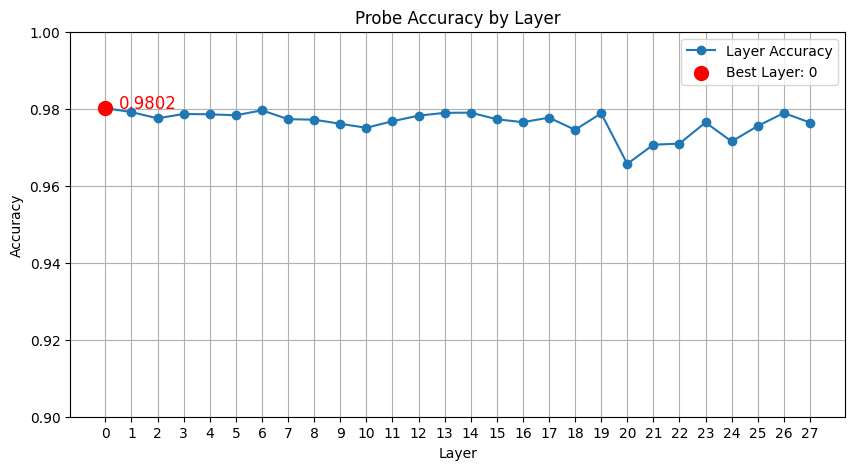

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("layer_probe_results.csv")

# Find best layer
best_row = df.loc[df['accuracy'].idxmax()]
best_layer = int(best_row['layer'])
best_acc = best_row['accuracy']

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df["layer"], df["accuracy"], marker="o", label="Layer Accuracy")
plt.scatter(best_layer, best_acc, color='red', s=100, zorder=5, label=f"Best Layer: {best_layer}")
plt.text(best_layer + 0.5, best_acc, f"{best_acc:.4f}", color='red', fontsize=12)

plt.title("Probe Accuracy by Layer")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(range(df["layer"].min(), df["layer"].max()+1))
plt.ylim(0.9, 1.0)
plt.legend()
plt.savefig("layer_probe_accuracy.png")
plt.show()


In [32]:
from google.colab import files
files.download('layer_probe_accuracy.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Mounting google drive in Colab


In [ ]:
# Creating folders
from google.colab import drive
import os

# mount Google Drive
drive.mount('/content/drive')

# Define the base folder path
base_dir = '/content/drive/MyDrive/LLM-Probing'

# Create folders

folders = [
    'Toy',
    'PTS',
    'PTS/logs'
]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Created folder: {folder_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Save the toy examples result to google docs





In [ ]:
import json
torch.save(model.state_dict(), '/content/drive/MyDrive/toy_probe_weights.pt')

with open('/content/drive/MyDrive/toy_probe_metrics.json', 'w') as f:
    json.dump({"val_accuracy": 0.82, "layer": 15}, f)


## Generate aligned token-level ```is_pivotal``` labels from the PTS dataset


Based on the data in the [PTS repo](https://github.com/codelion/pts)

We want to:
1. Tokenize the text(using Qwen tokenizer)
2. Align the pivotal words to tokens
3. Mark each token with a binary label
- `1` if it maps to a pivotal word
- `0` otherwise

In [ ]:
def get_token_labels(text, tokenizer, pivotal_words):
  # Tokenize text with character offsets

  encoded = tokenizer(text, return_offsets_mapping=True, return_tensors="pt")
  offsets = encoded.offset_mapping[0].tolist()
  tokens = tokenizer.convert_ids_to_tokens(encoded.input_ids[0])

  # Find character spans of each pivotal word
  token_labels = []
  for start, end in offsets:
    token_str = text[start:end]
    is_pivotal = any(token_str in word for word in pivotal_words)
    token_labels.append(1 if is_pivotal else 0)

  return encoded, token_labels

In [ ]:
'''
# Tokenize and run input
text = "The quick brown fox jumps over the lazy dog"
pivotal_words = ["quick", "jumps", "dog"]
inputs = tokenizer(text, return_tensors="pt")
# we don't want the model to update the parameters so we don't use gradient descent
with torch.no_grad():
    _ = model(**inputs)

'''


```pivotal_tokens``` should be a list of strings be a list of strings, like ```["quick", "jumps", "dogs"]```

In [ ]:
encoded, token_labels = get_token_labels(samples[0].text, tokenizer, samples[0].pivotal_words)

AttributeError: 'dict' object has no attribute 'text'

The Qwen2 uses a hidden size of 1024, that's the hidden_dim


In [ ]:
# Align activations with pivotal labels
resid = resid.squeeze(0) # [seq_len, 1024]
labels = torch.tensor(token_labels).float() # [seq_len]

In [ ]:
# Custom Collate Function
def flatten_collate(batch):
  x_list, y_list = zip(*batch)
  x = torch.cat(x_list, dim=0)
  y = torch.cat(y_list, dim=0)
  return x, y


## Evaluate Accuracy


In [ ]:
with torch.no_grad():
  correct, total = 0, 0
  for x, y in dataloader:
    preds = probe(x)
    preds = (preds >= 0.5).float()
    correct += (preds == y).sum().item()
    total += y.size(0)

  acc = correct/total
  print(f"Accuracy: {acc: .4f}")

NameError: name 'dataloader' is not defined